1. Users in test? 107068

# Merge data

In [1]:
DATA_PATH = "data"

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime 
from pathlib import Path
from tqdm.notebook import tqdm
import os

%matplotlib inline 

In [3]:
submission_df = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
test_user_ids = submission_df.Id
print("Unique test users:", test_user_ids.nunique())
submission_df.head(3)

Unique test users: 107068


,Id,Predicted
0,51,3239211 10720024 8493844 1965540 5009002 95218...
1,65,11693356 13392267 2464515 2245175 4748570 1134...
2,766,12773054 3692749 12726751 10041624 11893515 23...


In [4]:
product_counts = pd.read_csv("product-counts.csv")
# # 35.000 products cover ~97% of all orders
# most_popular_products = product_counts.product_id[:40000].tolist()

# 5.000 products cover ~50% of all orders
most_popular_products = product_counts.product_id[:5000].tolist()

# banany, smetane, moloko, ...
most_popular_products[:10]

del product_counts

In [5]:
def replace_date(date_str):
    if len(date_str) < 8:
        return '2020-10-09'
    else:
        return date_str

def str2date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except:
        date = datetime.datetime.strptime(date_str, '%d.%m.%Y')
    return date

def calculate_age(born):
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    if age < 10 or age > 70:
        age = 0
    return age

In [6]:
## Preprocess Users
user_df = pd.read_csv(os.path.join(DATA_PATH, "kaggle_tab_1345/tab_4_user_profiles.csv"))

uniq = user_df.user_id.nunique()
print(
    f"Users in original file {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Filter users not in test
user_df = user_df[user_df.user_id.isin(test_user_ids)]
uniq = user_df.user_id.nunique()
print(f"After filtering {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")

# Drop duplicates (352 / ~2% of the data)
user_df.drop_duplicates("user_id", inplace=True)

# Drop NaNs
user_df.dropna(inplace=True)
uniq = user_df.user_id.nunique()
print(f"After droping duplicates and NaN's {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")


# Replace incorrect dates
user_df.bdate = user_df.bdate.map(lambda x: replace_date(x))
# Convert all dates to datetime object
user_df.bdate = user_df.bdate.map(lambda x: str2date(x))
# Add new column with age
user_df["age"] = user_df.bdate.map(lambda x: calculate_age(x))
# Drop bdate column
user_df.drop(columns="bdate", inplace=True)
# Label code column
user_df.gender = user_df.gender.astype('category').cat.codes

print(f"Sanity check. Should be same as previous {len(user_df)}, unique {uniq}, diff {len(user_df) - uniq}")
user_df.head()

Users in original file 438867, unique 436927, diff 1940
After filtering 20764, unique 20412, diff 352
After droping duplicates and NaN's 8254, unique 8254, diff 0
Sanity check. Should be same as previous 8254, unique 8254, diff 0


,user_id,gender,age
10,1288925,1,38
43,1780454,0,0
48,534410,0,29
73,1050790,0,33
85,2119485,0,28


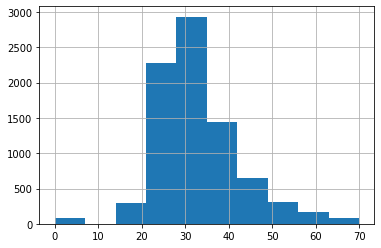

In [7]:
user_df.age.hist()

In [8]:
## Preprocess Citys
city_df = pd.read_csv(os.path.join(DATA_PATH, "tab_6_city.csv"))
city_df.city_name = city_df.city_name.astype('category').cat.codes
city_df.head(3)

,store_id,city_name
0,14,45
1,21,45
2,1,45


In [9]:
# diff is because correct primary key is [order_id, store_id]

## Preprocess Orders
orders_df = pd.read_csv(os.path.join(DATA_PATH, "kaggle_tab_1345/tab_1_orders.csv"))
uniq = orders_df.order_id.nunique()
print(f"Rows in original file {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
# Filter orders only from test users
orders_df = orders_df[orders_df.user_id.isin(test_user_ids)]
uniq = orders_df.order_id.nunique()
print(f"After filtering {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Drop duplicates
orders_df.drop_duplicates(["order_id", "store_id"], inplace=True)
uniq = orders_df.order_id.nunique()
print(f"After dropping duplicates {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")

# Label code columns
orders_df.retailer = orders_df.retailer.astype('category').cat.codes
orders_df.platform = orders_df.platform.astype('category').cat.codes

# # Merge city data
# orders_df = orders_df.set_index('store_id').join(city_df.set_index('store_id'))
# orders_df.reset_index(inplace=True)
# # # Merge user data
# orders_df = orders_df.set_index('user_id').join(user_df.set_index('user_id'))
# orders_df.reset_index(inplace=True)

uniq = orders_df.order_id.nunique()
print(f"Sanity check. Should be same as previous {len(orders_df)}, unique {uniq}, diff {len(orders_df) - uniq}")
orders_df.head()

Rows in original file 2461958, unique 2426955, diff 35003
After filtering 967345, unique 953436, diff 13909
After dropping duplicates 967340, unique 953436, diff 13904
Sanity check. Should be same as previous 967340, unique 953436, diff 13904


,user_id,order_id,order_created_time,retailer,store_id,platform
3,187,15952443,2020-09-01 17:34:00,16,533,0
15,400,11911561,2020-06-13 13:26:03,2,11,0
16,400,11922112,2020-06-13 16:30:57,2,11,0
17,400,12264981,2020-06-19 11:57:25,2,11,0
18,400,12749996,2020-06-29 19:14:42,2,11,0


In [10]:
# Add new feature
orders_df['order_created_time'] = pd.to_datetime(orders_df['order_created_time'])
tmp = orders_df.drop_duplicates(["order_id"]).sort_values(by=["user_id", "order_id", "order_created_time"])
tmp['day_since_prior_order'] = tmp.groupby(['user_id'])['order_created_time'].diff().dt.days.fillna(-1)
orders_df = orders_df.merge(tmp[["order_id", "day_since_prior_order"]])
del tmp

In [11]:
orders_df.dtypes

user_id                           int64
order_id                          int64
order_created_time       datetime64[ns]
retailer                           int8
store_id                          int64
platform                           int8
day_since_prior_order           float64
dtype: object

In [12]:
# Convert to reduce memory usage
orders_df = orders_df.astype({
        'user_id': 'int32',
        'order_id': 'int32',
        'retailer': 'int8',
        'store_id': 'int16',
        'platform': 'int8',
        'day_since_prior_order': 'int16'}, copy=False)

In [28]:
# orders_df.city_name.hist()

In [13]:
## Preprocess Products
pathes = sorted(list(Path(DATA_PATH).glob('*/tab_2*.csv')))
dfs = []

for path in tqdm(pathes):
    # Read DF
    df = pd.read_csv(path)
    
    # Filter: delete users not from test and not popular products
    df = df[df.user_id.isin(test_user_ids) & df.product_id.isin(most_popular_products)]

    # Drop column with long desciption
    df.drop(columns=["product_name"], inplace=True)
    
    # Label code column
    df.brand_name = df.brand_name.astype('category').cat.codes
    
    # Fill NaNs in one column
    df.master_category_id.fillna(-1, inplace=True)
    dfs.append(df)

In [14]:
products_df = pd.concat(dfs)
del dfs
print("Num rows in filtered products:", len(products_df)) # 21677070
print("Num unique products:", products_df.product_id.nunique()) # 91994

Num rows in filtered products: 12563262
Num unique products: 5000


In [16]:
# Compare `orders_id`
orders_from_orders = set(orders_df.order_id)
orders_from_products = set(products_df.order_id)
print(f"Orders: {len(orders_from_orders)}, Products: {len(orders_from_products)}")
print(f"Intersection: {len(orders_from_orders.intersection(orders_from_products))}")
print(f"Difference orders: {len(orders_from_orders.difference(orders_from_products))}")
print(f"Difference products: {len(orders_from_products.difference(orders_from_orders))}")

# Not for all users/orders in Products table we can find corresponding element in Orders to get additional features

Orders: 953436, Products: 825696
Intersection: 780813
Difference orders: 172623
Difference products: 44883


In [17]:
# Mean order size per user
mean_orders = (products_df.groupby(["user_id", "order_id"])
                         .agg({'line_item_id':'count'})
                         .groupby("user_id").mean()
                         .rename(columns={'line_item_id':'mean_order_size'}))

products_df = products_df.merge(mean_orders, on='user_id')
del mean_orders

In [18]:
products_df.dtypes

user_id                 int64
order_id                int64
line_item_id            int64
price                 float64
quantity                int64
discount              float64
product_id              int64
brand_name              int16
master_category_id    float64
parent_category_id      int64
mean_order_size       float64
dtype: object

In [19]:
products_df = products_df.astype({
        'user_id': 'int32',
        'order_id': 'int32',
        'line_item_id': 'int32',
        'price': 'float32',
        'quantity': 'int32',
        'discount': 'float32',
        'product_id': 'int32',
        'brand_name': 'int16',
        'master_category_id': 'int32',
        'parent_category_id': 'int32',
        'mean_order_size': 'float32'}, copy=False)

In [20]:
# Merge Orders data
tmp = orders_df.drop_duplicates("order_id").drop(columns="user_id")
merged_df = products_df.merge(tmp, how='left', on='order_id')
merged_df.head()
del tmp, products_df

In [97]:
len(merged_df) # 20779975

12006535

**Finished generating GENERAL tables**

# Train data split

In [98]:
# Drop NaN's from merged_df (~5% of the data) (No info about order date)
merged_df.dropna(inplace=True)
print("After dropping NaN's:", len(merged_df))

After dropping NaN's: 12006535


In [25]:
NUM_USERS = 5000
users = merged_df.user_id.unique()
# Take a subset first to make debug faster
train_users = users[:NUM_USERS]
print(f"Training size: {len(most_popular_products) * len(train_users)}") # 25000000

In [27]:
# Generate empty df with # rows = len(user_id) x len(product_id) all unique
import itertools
data = list(itertools.product(most_popular_products, train_users))

In [28]:
df_data = {
    "product_id": [x[0] for x in data],
    "user_id": [x[1] for x in data]
}

In [29]:
X_train = pd.DataFrame(df_data)

In [31]:
last_order_date = merged_df.groupby(['user_id'])['order_created_time'].max().to_frame('order_created_time').reset_index()
last_order_df = pd.merge(merged_df, last_order_date, on=['user_id', 'order_created_time']) 


In [ ]:
target = pd.merge(merged_df, last_order_date, on=['user_id', 'order_created_time']) 

target_user_product_pos = target[['user_id', 'product_id']]
target_user_product_pos['target'] = 1
target_user_product_pos.drop_duplicates(inplace=True)

In [35]:
X_train = X_train.merge(target_user_product_pos, how='left')
X_train.fillna(value=0, inplace=True)
X_train.head()

,product_id,user_id,target
0,709,766,0.0
1,709,1012,0.0
2,709,1132,0.0
3,709,2131,0.0
4,709,3011,0.0


In [37]:
train_order_ids = target["order_id"].unique()

In [38]:
# Use this data to generate features
X_prior = merged_df[~merged_df.order_id.isin(train_order_ids)]

# Features

## Product Features

In [ ]:
"product_total_orders", "product_avg_order_dow", "product_avg_order_hour_of_day"

In [49]:
product_total_orders = X_prior.groupby(['product_id']).size().reset_index().rename(columns={0:'product_total_orders'})



In [129]:
tmp = X_prior[["product_id", "order_created_time"]]
tmp["order_dow"] = tmp["order_created_time"].dt.weekday
tmp["order_hour"] = tmp["order_created_time"].dt.hour + tmp["order_created_time"].dt.minute / 60.0

In [130]:
product_avg_order_dow = tmp.groupby("product_id").agg(
    product_avg_order_dow=pd.NamedAgg(column='order_dow', aggfunc='mean')).reset_index()

product_avg_order_hour_of_day = tmp.groupby("product_id").agg(
    product_avg_order_hour_of_day=pd.NamedAgg(column='order_hour', aggfunc='mean')).reset_index()

## User features

In [ ]:
"user_total_orders", "user_total_products", "user_avg_cartsize"

In [110]:
# X_prior.groupby(['user_id', 'order_id']).size()
user_total_orders = (X_prior.groupby(['user_id'])['order_id']
     .nunique().to_frame('count')
     .reset_index()
     .rename(columns={'count':'user_total_orders'}))


In [111]:
user_total_orders

,user_id,user_total_orders
0,400,4
1,576,7
2,608,3
3,766,20
4,1012,9
...,...,...
83230,3127156,1
83231,3128356,1
83232,3130099,1
83233,3133198,1


In [59]:
# Total number of different product in all user orders
user_total_products = (X_prior.drop_duplicates(["user_id", "product_id"])
     .groupby("user_id")
     .size().reset_index()
     .rename(columns={0:'user_total_products'}))

In [143]:
# Mean order size per user
user_avg_cartsize = (X_prior.groupby(["user_id", "order_id"])
                         .agg({'line_item_id':'count'})
                         .groupby("user_id").mean()
                         .rename(columns={'line_item_id':'user_avg_cartsize'})).reset_index()


## User product features

In [ ]:
"user_product_total_orders" "user_product_order_freq"

In [76]:
user_product_total_orders = X_prior.groupby(
     ['user_id', 'product_id']).agg(
     user_product_total_orders=pd.NamedAgg(column='product_id', aggfunc='count')).reset_index()

In [116]:
# user_product_total_orders

In [117]:
tmp = user_product_total_orders.merge(user_total_orders)
tmp["user_product_order_freq"] = tmp.user_product_total_orders / tmp.user_total_orders
user_product_order_freq = tmp[["user_id", "product_id", "user_product_order_freq"]]
# user_product_order_freq

In [ ]:
# features = X_prior.groupby(['user_id', 'product_id', 'master_category_id', 
#                             'parent_category_id']).agg(
#     product_count=pd.NamedAgg(column='product_id', aggfunc='count'),
#     avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
#     max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
#     min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
#     avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
#     max_price=pd.NamedAgg(column='price', aggfunc='max'),
#     min_price=pd.NamedAgg(column='price', aggfunc='min'),
#     last_date_purchase=pd.NamedAgg(column='order_created_time', aggfunc='max'),

## Order features

In [ ]:
"order_dow", "order_time"

In [71]:
last_order_date["order_dow"] = last_order_date.order_created_time.apply(lambda x: x.weekday())
# UTC+0 time!
last_order_date["order_time"] = last_order_date.order_created_time.apply(lambda x: x.hour + x.minute / 60.0)

In [154]:
order_dow = last_order_date[["user_id", "order_dow"]]
order_time = last_order_date[["user_id", "order_time"]]

## Order product features

In [ ]:
"last_purchase_days_ago"

In [78]:
last_date_purchase = X_prior.groupby(
     ['user_id', 'product_id']).agg(
     last_date_purchase=pd.NamedAgg(column='order_created_time', aggfunc='max')).reset_index()

In [95]:
tmp = last_order_date.merge(last_date_purchase)

tmp["last_purchase_days_ago"] = (tmp.order_created_time - tmp.last_date_purchase).dt.days
last_purchase_days_ago = tmp[["user_id", "product_id", "last_purchase_days_ago"]]
 #.apply(lambda x: x.dt.days())

# Merge features into train data

In [120]:
X_train.head()

,product_id,user_id,target
0,709,766,0.0
1,709,1012,0.0
2,709,1132,0.0
3,709,2131,0.0
4,709,3011,0.0


In [123]:
X_train = X_train.merge(product_total_orders)

X_train = X_train.merge(product_avg_order_dow)

X_train = X_train.merge(product_avg_order_hour_of_day)

In [137]:
X_train = X_train.merge(user_total_orders, how="left")

X_train = X_train.merge(user_total_products, how="left")

X_train = X_train.merge(user_avg_cartsize, how="left")

In [150]:
X_train = X_train.merge(user_product_total_orders, how="left")

X_train = X_train.merge(user_product_order_freq, how="left")

In [157]:
X_train = X_train.merge(order_dow, how="left")
X_train = X_train.merge(order_time, how="left")

In [161]:
X_train = X_train.merge(last_purchase_days_ago, how="left")

In [165]:
X_train

,product_id,user_id,target,product_total_orders,product_avg_order_dow,product_avg_order_hour_of_day,user_total_orders,user_total_products,user_avg_cartsize,user_product_total_orders,user_product_order_freq,order_dow,order_time,last_purchase_days_ago
0,709,766,0.0,120137,3.045814,12.277780,20,140,9.500000,1.0,0.05,0,9.766667,213.0
1,39590,766,0.0,36029,3.043576,11.986180,20,140,9.500000,NaN,NaN,0,9.766667,NaN
2,166,766,0.0,30115,3.092047,11.619395,20,140,9.500000,NaN,NaN,0,9.766667,NaN
3,55133,766,1.0,29620,3.068501,12.544262,20,140,9.500000,NaN,NaN,0,9.766667,NaN
4,1300,766,0.0,26270,3.067377,12.293673,20,140,9.500000,NaN,NaN,0,9.766667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24594995,25355,74341,0.0,844,3.161137,11.912539,24,330,26.166667,NaN,NaN,3,21.616667,NaN
24594996,5482080,74341,0.0,924,3.053030,9.723737,24,330,26.166667,NaN,NaN,3,21.616667,NaN
24594997,23501,74341,0.0,781,3.138284,12.187452,24,330,26.166667,NaN,NaN,3,21.616667,NaN
24594998,7114,74341,0.0,774,2.981912,11.856783,24,330,26.166667,NaN,NaN,3,21.616667,NaN


# Train model

In [162]:
from sklearn.linear_model import LogisticRegression

In [175]:
lr = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000, verbose=1, n_jobs=12)

In [170]:
X_train_final = X_train.drop(columns=['product_id','user_id','target'])
# y_train = X_train["target"]

In [172]:
X_train_final.fillna(-1, inplace=True)

In [ ]:
lr.fit(X_train_final, y_train)

[LibLinear]

In [ ]:
X_tr, X_te = df_X_tr, \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
lr_10x.fit(X_tr, y_tr)

In [65]:
target = pd.merge(merged_df, last_order, on=['user_id', 'order_created_time'], ) 
# train_order_id = target["order_id"].unique()
train_order_id
target.head()
# print(len(target))

# target_user_product_pos = target[['user_id', 'product_id']]
# target_user_product_pos['target'] = 1
# target_user_product_pos = target_user_product_pos.drop_duplicates()
# target_user_product_pos.head(3)

,user_id,order_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,mean_order_size,order_created_time,retailer,store_id,platform,day_since_prior_order
0,766,15872781,165315688,192.809998,1,30.00,5481688,-1,591.0,90,18.130435,2020-08-31 09:46:25,2.0,2.0,2.0,171.0
1,766,15872781,165316130,199.000000,1,100.00,92338,1884,91.0,90,18.130435,2020-08-31 09:46:25,2.0,2.0,2.0,171.0
2,766,15872781,165316378,31.900000,4,11.59,103039,3002,584.0,479,18.130435,2020-08-31 09:46:25,2.0,2.0,2.0,171.0
3,766,15872781,165317686,24.900000,4,10.09,5659264,-1,600.0,56,18.130435,2020-08-31 09:46:25,2.0,2.0,2.0,171.0
4,766,15872781,165318905,284.000000,1,89.00,69731,2005,45.0,42,18.130435,2020-08-31 09:46:25,2.0,2.0,2.0,171.0


In [ ]:
# Data type conversion
products_df.drop(columns=["line_item_id", "order_created_time"], inplace=True)
products_df.fillna(-1, inplace=True)
products_df = products_df.astype({
        'user_id': 'int32',
        'order_id': 'int32',
        'price': 'float32',
        'quantity': 'int32',
        'discount': 'float32',
        'product_id': 'int32',
        'brand_name': 'int16',
        'master_category_id': 'int32',
        'parent_category_id': 'int32',
        'mean_order_size': 'float32',
        'store_id': 'int16',
        'retailer': 'int16',
        'platform': 'int8',
        'city_name': 'int16',
        'gender': 'int8',
        'age': 'int8',
        'day_since_prior_order': 'int16'}, copy=False)

In [124]:
merged_df['count'] = 1
df_agg = merged_df.groupby(["user_id", "product_id"]).agg({'count':sum})
g = df_agg['count'].groupby(level=0, group_keys=False)

In [125]:
res = g.nlargest(50)
res.reset_index(inplace=True)
res.product_id = res.product_id.astype('str')
submit = res.groupby('user_id')['product_id'].apply(' '.join).reset_index()
submit.columns = ["Id", "Predicted"]
submit.to_csv("my_sumbit1.csv", index=False)

# Merge best submissions

In [82]:
best1_df = pd.read_csv("1_submission_04_masha_sunday.csv")
best2_df = pd.read_csv("2_test_submission_08.csv")
best3_df = pd.read_csv("3_emils_with_10cf.csv")

best1_df.sort_values("Id", inplace=True)
best2_df.sort_values("Id", inplace=True)
best3_df.sort_values("Id", inplace=True)

In [84]:
merged_predicted = (best1_df.Predicted + best2_df.Predicted + best3_df.Predicted).apply(lambda x: x.split(' '))

merged_predicted = merged_predicted.apply(lambda x: [int(k) for k in x])

In [112]:
def filter_popular(predicted):
    counter = Counter(predicted)
    count_1, count_2, count_3 = [], [], []
    for elem in predicted:
        if elem == 0:
            continue
        if counter[elem] == 3:
            if elem not in count_3:
                count_3.append(elem)
        elif counter[elem] == 2:
            if elem not in count_2:
                count_2.append(elem)
        else:
            if elem not in count_1:
                count_1.append(elem)

        if len(count_3) == 50:
            return " ".join([str(x[0]) for x in count_3])
        
    result = count_3 + count_2[:50 - len(count_3)] + count_1[:50 - len(count_3) - len(count_2[:50 - len(count_3)])]
#     assert len(result) == 50, f"Too short! {len(result)}. {len(count_3)}, {len(count_2)}, {len(count_1)}"
#     print(result)
    return " ".join([str(x) for x in result])



In [114]:
best1_df["Predicted"] = merged_predicted.apply(lambda x: filter_popular(x))
best1_df.to_csv("merged3_no_month_filter_ordered.csv", index=False)